<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">Authors</div><br></div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D

Axes3D

matplotlib.rc("figure", figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment is about implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning algorithms.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should take a value in `[0,1]`.
* This method just store the parameters in the fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to computed the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from sklearn.utils.extmath import svd_flip

In [32]:
class DM(TransformerMixin, BaseEstimator):
    """
        Diffusion Maps.
    """
    def __init__(self, sigma, n_components, step=1, alpha=1, kernel_type='rbf'):
        # Assignment of the hyper-parameters (you can complete it).
        self.sigma = sigma
        self.n_components = n_components
        self.step = step
        self.alpha = alpha
        self.kernel_type = kernel_type  # selection for affinity matrix
    
    def K(self, X, Y=None):
        if self.kernel_type == 'rbf':
            return rbf_kernel(X, Y, gamma=1/(2*self.sigma**2))
        if self.kernel_type == 'laplacian':
            return laplacian_kernel(X, Y, gamma=1/(2*self.sigma**2))
        
    def fit(self, X, y=None):
        """Compute the embedding vectors for data X
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """

        # Kernel definition
        K = self.K(X)

        #D = np.diag(K.sum(axis=1))
        # Compute Distance Diffusion
        #D = K.sum(axis=0)
        D = K.sum(axis=1).reshape(-1,1)

        # Stationary Distribution
        pi = D / np.sum(D)

        # Transition Probability Matrix definition
            # Probability of arriving from i to j in one step
        #k_ij = D @ K @ D
        #d_i = np.sum(k_ij, axis=0).T
        #P =  k_ij / d_i
        P = K / D

        # P reduced to orthonormal basis by diagonal matrix
        A = K / np.sqrt(D)

        # Obtain the DVD decomposition
        eigenvectors, eigenvalues, V = np.linalg.svd(A, full_matrices=True)

        # Eigenvectors sign correction and normalization
        eigenvectors, _ = svd_flip(eigenvectors, V) / np.sqrt(pi)

        # Save eigenvecs and eigenvalues
        self.eigenvectors = eigenvectors[:, 1:]
        self.eigenvalues = eigenvalues[1 :]
        return self

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        X_red = self.transform(X)
        return X_red
    
    def transform(self, X):
        """Transform X.
        This function is implemented using the Nyström formula.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features).
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """

        eigenvectors = self.eigenvectors[:, : self.n_components]
        eigenvalues = self.eigenvalues[: self.n_components]

        # Compute Transition step
        T = eigenvectors * eigenvalues**self.step

        # Step transform
        X_red = X @ T
        
        return X_red

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

## Dataset 1: two blobs

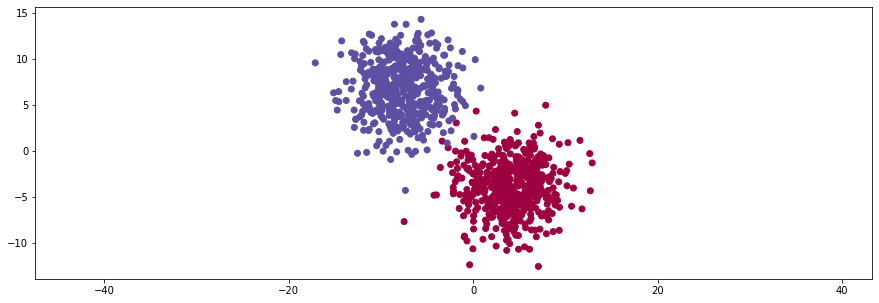

In [12]:
N = 1000

X, y = make_blobs(
    n_samples=N, n_features=50, centers=2, cluster_std=3.0, random_state=seed
)
y[y != 1] = -1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
plt.axis("equal")
plt.show()

N_new = 100
X_new, y_new = make_blobs(
    n_samples=N_new, n_features=50, centers=2, cluster_std=3.0, random_state=seed + 1
)

In [33]:
# Solution here

dm = DM(sigma=.2, n_components=2, kernel_type='rbf')

In [34]:
dm.fit_transform(X)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 1)

## Dataset 2: the swiss roll

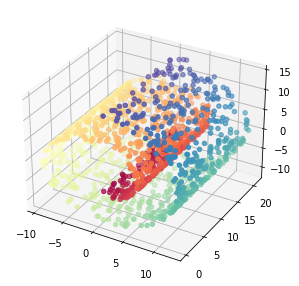

In [8]:
N = 1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed + 1)

In [ ]:
# Solution here

## Dataset 3: the S curve

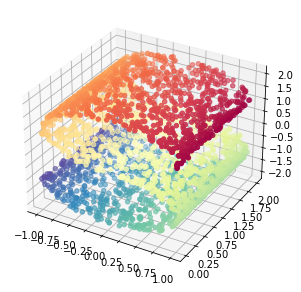

In [10]:
N = 3000
X, color = make_s_curve(N, random_state=seed)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed + 1)

In [ ]:
# Solution here

<div class="qst">

1. Do you consider that the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
    
2. How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.
    * Check how much influence the sample density (you can vary N for each dataset).
    * Check what happens if the number of steps `steps` grows.
   
    
3. In your opinion, which is the main advantage and disadvantage of this method?
    
</div>

**Answer**: